In [2]:
import torch.nn as nn
import torch.nn.functional as F

class no_dropout(nn.Module):

    def __init__(self, hidden_size):

        super().__init__()

        self.linear_1 = nn.Linear(1, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, 1)

    def forward(self, input):

        output = F.relu(self.linear_1(input))
        output = F.relu(self.linear_2(output))
        output = self.linear_3(output)
        return output

In [3]:
class with_dropout(nn.Module):

    def __init__(self, hidden_size):

        super().__init__()

        self.linear_1 = nn.Linear(1, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.20)

    def forward(self, input):

        output = F.relu(self.dropout(self.linear_1(input)))
        output = F.relu(self.dropout(self.linear_2(output)))
        output = self.linear_3(output)
        return output

In [4]:
from fbm_dropout.fbm_dropout import DropoutFBM

class with_fbm_dropout(nn.Module):

    def __init__(self, hidden_size, hurst, n_agents, n_samples, max_iters, t_scale, grid_size):

        super().__init__()

        self.linear_1 = nn.Linear(1, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, 1)
        self.dropout_1 = DropoutFBM(hurst, n_agents, n_samples, max_iters, t_scale, grid_size)
        self.dropout_2 = DropoutFBM(hurst, n_agents, n_samples, max_iters, t_scale, grid_size)

    def forward(self, input):
        if self.training:
            output = F.relu(self.dropout_1(self.linear_1(input)))
            output = F.relu(self.dropout_2(self.linear_2(output)))
        else:
            output = F.relu(self.linear_1(input))
            output = F.relu(self.linear_2(output))

        output = self.linear_3(output)
        return output

In [5]:
from fbm_dropout.dataset import get_toy_dataset
import torch

trainset, testset = get_toy_dataset(n_train=50, n_test=50, noise=.3)
(X_train, Y_train) = trainset
(X_test, Y_test) = testset

batch_size = 1
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [10]:
hidden_size = 100

# define three models: no dropout, dropout, fbm dropout
no_dropout_model = no_dropout(hidden_size)
with_dropout_model = with_dropout(hidden_size)
with_fbm_dropout_model = with_fbm_dropout(hidden_size, hurst=0.9, n_agents=12, n_samples=50, 
                                          max_iters=500, t_scale=10, grid_size=(10,10))

# three optimizers for three models
no_dropout_opt = torch.optim.Adam(no_dropout_model.parameters(), lr=0.01)
with_dropout_opt = torch.optim.Adam(with_dropout_model.parameters(), lr=0.01)
with_fbm_dropout_opt = torch.optim.Adam(with_fbm_dropout_model.parameters(), lr=0.01)
# same loss function
loss_fn = torch.nn.MSELoss()

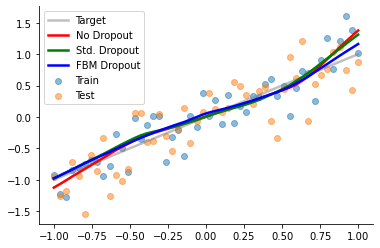

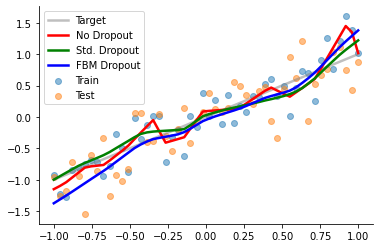

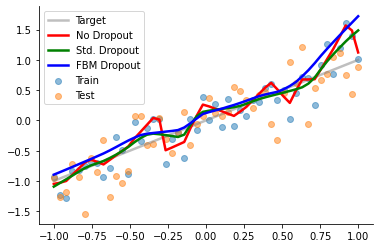

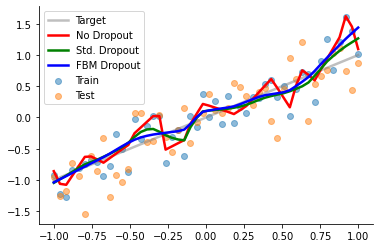

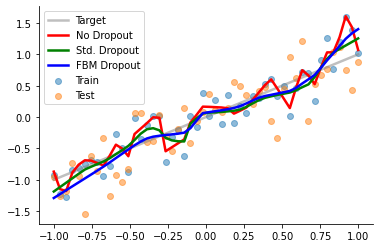

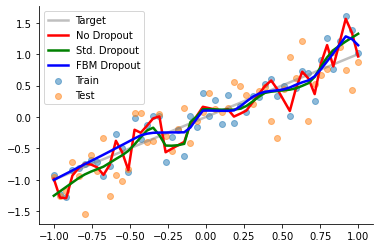

In [11]:
import matplotlib.pyplot as plt

results = {}
results['train_loss'] = {}
results['train_loss']['standard'] = []
results['train_loss']['dropout'] = []
results['train_loss']['fbm'] = []
results['test_loss'] = {}
results['test_loss']['standard'] = []
results['test_loss']['dropout'] = []
results['test_loss']['fbm'] = []
results['dropout_rate_1'] = []
results['dropout_rate_2'] = []

for iter in range(1, 51):
    no_dropout_model.train()
    with_dropout_model.train()
    with_fbm_dropout_model.train()
    
    results['train_loss']['standard'].append(0)
    results['train_loss']['dropout'].append(0)
    results['train_loss']['fbm'].append(0)
    for x, y in zip(X_train, Y_train):
        pred = no_dropout_model(X_train) # look at the entire data in a single shot
        loss = loss_fn(pred, Y_train)
        no_dropout_opt.zero_grad()
        loss.backward()
        no_dropout_opt.step()
        
        pred_dropout = with_dropout_model(X_train)
        loss_dropout = loss_fn(pred_dropout, Y_train)
        with_dropout_opt.zero_grad()
        loss_dropout.backward()
        with_dropout_opt.step()

        pred_fbm_dropout = with_fbm_dropout_model(X_train)
        loss_fbm_dropout = loss_fn(pred_fbm_dropout, Y_train)
        with_fbm_dropout_opt.zero_grad()
        loss_fbm_dropout.backward()
        with_fbm_dropout_opt.step()

        results['train_loss']['standard'][-1] += loss.item()
        results['train_loss']['dropout'][-1] += loss_dropout.item()
        results['train_loss']['fbm'][-1] += loss_fbm_dropout.item()
    
    results['train_loss']['standard'][-1] /= 50
    results['train_loss']['dropout'][-1] /= 50
    results['train_loss']['fbm'][-1] /= 50

    results['dropout_rate_1'].append(with_fbm_dropout_model.dropout_1.cum_dropout_rate)
    results['dropout_rate_2'].append(with_fbm_dropout_model.dropout_2.cum_dropout_rate)

    no_dropout_model.eval()
    with_dropout_model.eval()
    with_fbm_dropout_model.eval()
    
    test_pred = no_dropout_model(X_test)
    test_loss = loss_fn(test_pred, Y_test)
    
    test_pred_dropout = with_dropout_model(X_test)
    test_loss_dropout = loss_fn(test_pred_dropout, Y_test)

    test_pred_fbm_dropout = with_fbm_dropout_model(X_test)
    test_loss_fbm_dropout = loss_fn(test_pred_fbm_dropout, Y_test)

    results['test_loss']['standard'].append(test_loss.item())
    results['test_loss']['dropout'].append(test_loss_dropout.item())
    results['test_loss']['fbm'].append(test_loss_fbm_dropout.item())

    if iter == 1 or iter % 10 == 0:
        
        fig, ax = plt.subplots(facecolor=(1, 1, 1))
        ax.scatter(X_train.data.numpy(), Y_train.data.numpy(), alpha=0.5, label='Train')
        ax.scatter(X_test.data.numpy(), Y_test.data.numpy(), alpha=0.5, label='Test')
        ax.plot(X_test.data.numpy(), X_test.data.numpy(), lw=2.5, c='gray', alpha=0.5, label='Target')

        ax.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=2.5, label='No Dropout')
        ax.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'g-', lw=2.5,  label='Std. Dropout')
        ax.plot(X_test.data.numpy(), test_pred_fbm_dropout.data.numpy(), 'b-', lw=2.5,  label='FBM Dropout')

        #plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f, Loss with fbm dropout = %0.4f, Dropout rates = [%0.2f, %0.2f]' % (epoch, test_loss, test_loss_dropout, test_loss_fbm_dropout, dr1, dr2))
        ax.legend()
        title = 'figure_3_epoch_{}.tif'.format(iter)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        plt.savefig(title, dpi=300)
        plt.show()

    with_fbm_dropout_model.dropout_1.branch_off()
    with_fbm_dropout_model.dropout_2.branch_off()
        

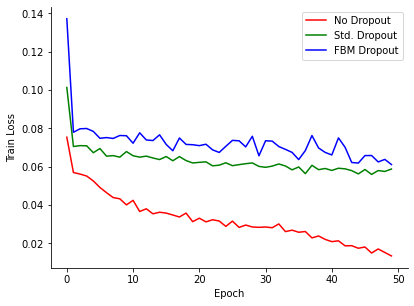

In [31]:
fig, ax = plt.subplots(figsize=(6.4, 4.8), facecolor=(1,1,1))

ax.plot(results['train_loss']['standard'], c='r', label='No Dropout')
ax.plot(results['train_loss']['dropout'], c='g', label='Std. Dropout')
ax.plot(results['train_loss']['fbm'], c='b', label='FBM Dropout')
ax.set_ylabel('Train Loss')
ax.set_xlabel('Epoch')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('fig3_train_loss.tif', dpi=300)
plt.show()

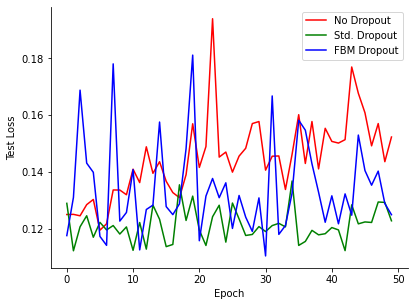

In [32]:
fig, ax = plt.subplots(figsize=(6.4, 4.8), facecolor=(1,1,1))

ax.plot(results['test_loss']['standard'][:500], c='r', label='No Dropout')
ax.plot(results['test_loss']['dropout'][:500], c='g', label='Std. Dropout')
ax.plot(results['test_loss']['fbm'][:500], c='b', label='FBM Dropout')
ax.set_ylabel('Test Loss')
ax.set_xlabel('Epoch')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('fig3_test_loss.tif', dpi=300)
plt.show()

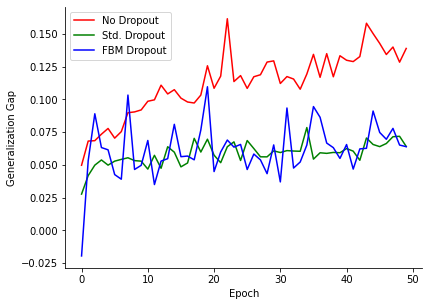

In [34]:
fig, ax = plt.subplots(figsize=(6.4, 4.8), facecolor=(1,1,1))

ax.plot([x-y for x, y in zip(results['test_loss']['standard'],results['train_loss']['standard'])][:500], c='r', label='No Dropout')
ax.plot([x-y for x, y in zip(results['test_loss']['dropout'],results['train_loss']['dropout'])][:500], c='g', label='Std. Dropout')
ax.plot([x-y for x, y in zip(results['test_loss']['fbm'],results['train_loss']['fbm'])][:500], c='b', label='FBM Dropout')
ax.set_ylabel('Generalization Gap')
ax.set_xlabel('Epoch')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('fig3_generalization_gap.tif', dpi=300, bbox_inches='tight')
plt.show()